# Introduction to Rockpool

## No use crying over spilt time

## Importing Rockpool modules

In [1]:
# - Switch off warnings
import warnings
warnings.filterwarnings("ignore")

# - Import classes to represent time series data
from rockpool import TimeSeries, TSContinuous, TSEvent

# - Import `Module` classes to use
from rockpool.nn.modules import Rate, Linear

In [2]:
# - Import numpy
import numpy as np

# - Import the plotting library
import sys
!{sys.executable} -m pip install --quiet matplotlib rich
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams["figure.figsize"] = [12, 4]
plt.rcParams["figure.dpi"] = 300

# - Rich printing
from rich import print

## My First Module

In [3]:
# - Define a feed-forward module with `N` neurons
N = 4
mod = Rate(N)
print(mod)

Rate  with shape (4,)

In [4]:
print(mod.state())
print(mod.parameters())
print(mod.simulation_parameters())

{'x': array([0., 0., 0., 0.])}

{'tau': array([0.02, 0.02, 0.02, 0.02]), 'bias': array([0., 0., 0., 0.]), 'threshold': array([0., 0., 0., 0.])}

{'dt': 0.001, 'noise_std': 0.0, 'act_fn': <function H_ReLU at 0x172ca81f0>}

We can *evolve* the state of these neurons over time, by providing some input to the module by calling it. Low-level modules accept clocked input data as raw `numpy` arrays with shape `(T, N)`, or with shape `(batches, T, N)`. If an array `(T, N)` is provided, it will be converted to a single batch.

Let's create some simple input.

In [5]:
T = 100
input_clocked = np.random.randn(T, N) * 3

# - Evolve the module with the input
output_clocked, new_state, recorded_state = mod(input_clocked)

# - Update the state of the module
mod = mod.set_attributes(new_state)

`output_clocked` represents the output of the neurons, which is a n`numpy` array with shape `(1, T, N)`. We can visualise this using `matplotlib`.

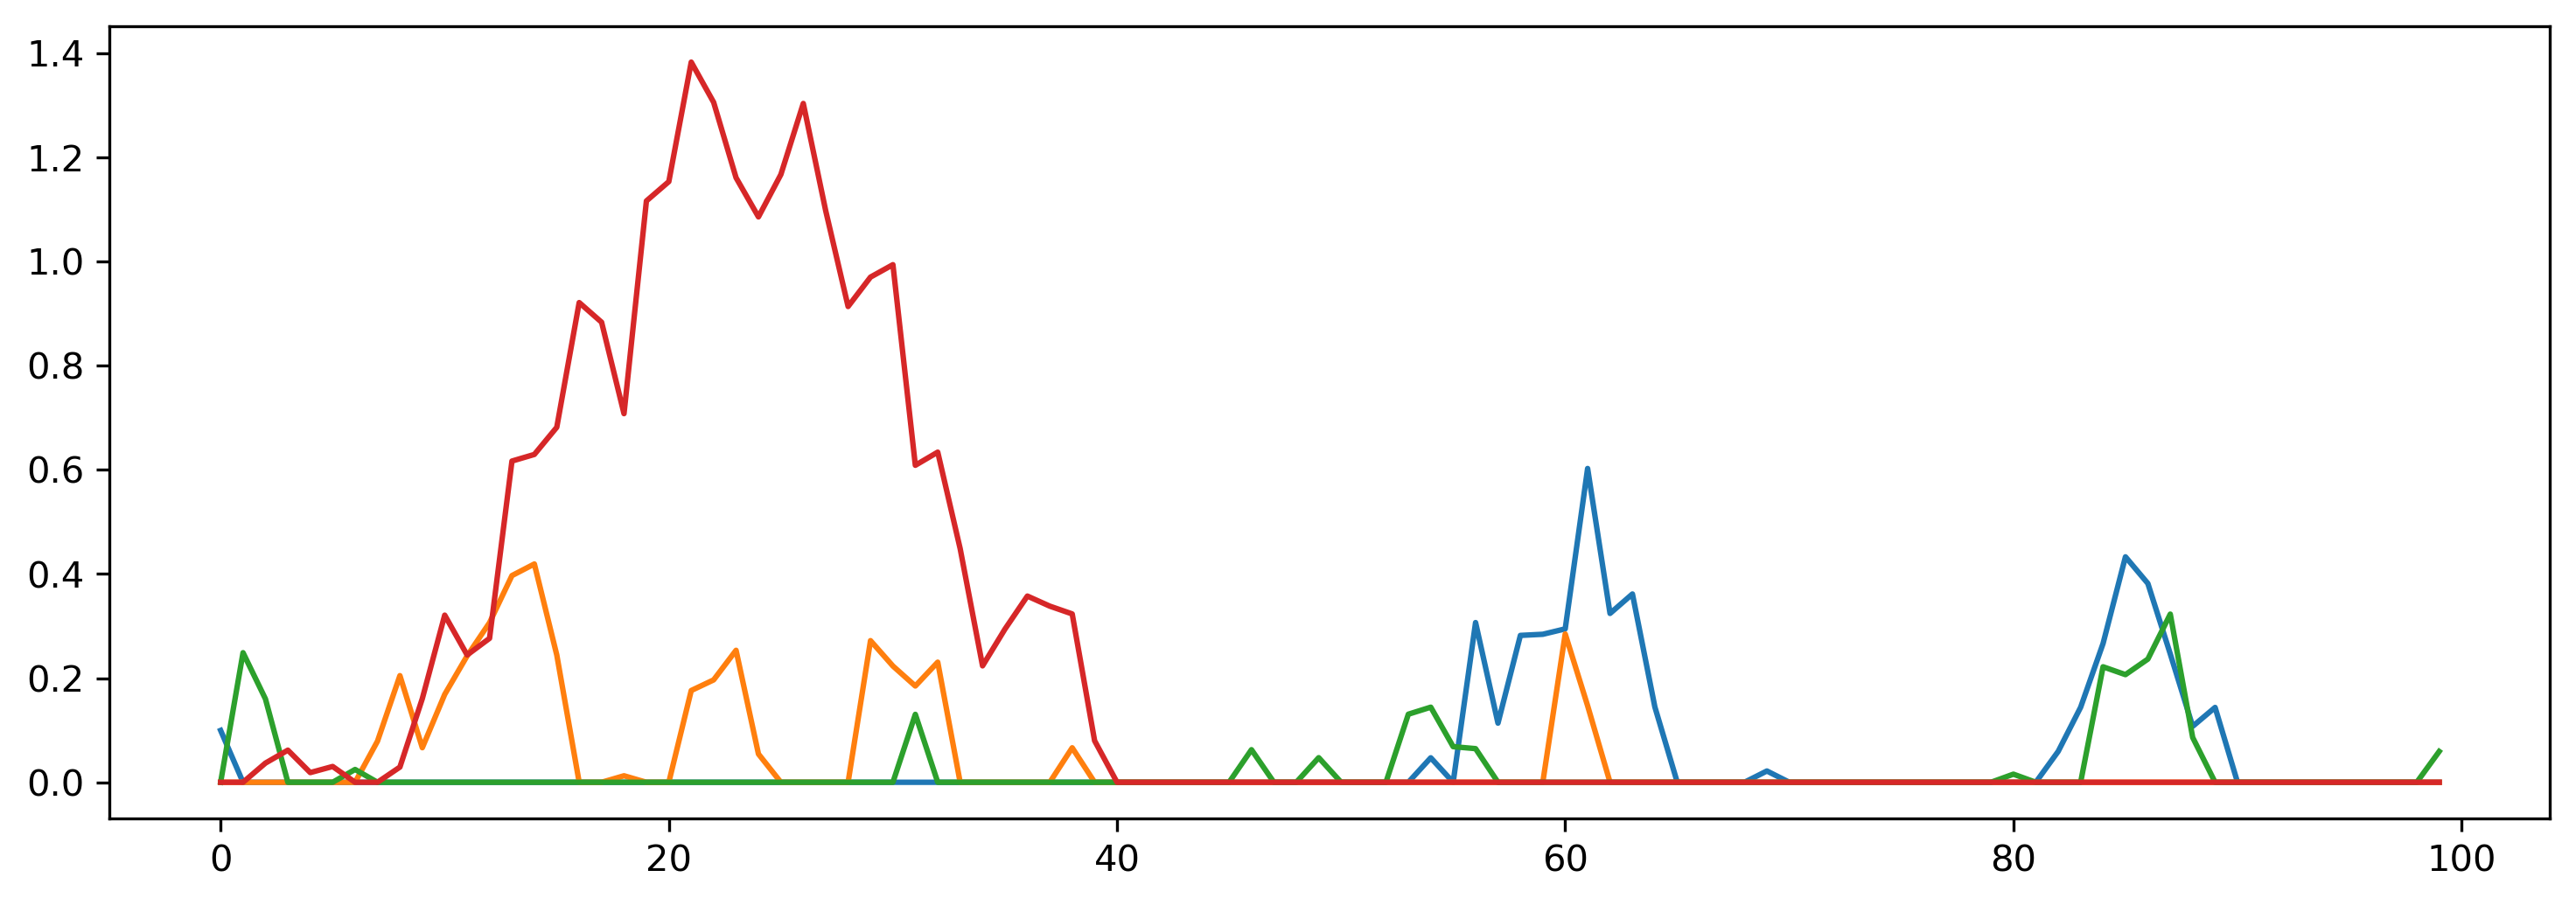

In [6]:
plt.plot(output_clocked[0]);

## Getting things done in time

In [7]:
# - Use the `.timed()` method to obtain a TimeSeries interface
tmod = mod.timed()
print(tmod)

TimedModuleWrapper  with shape (4, 4) {
    Rate '_module' with shape (4,)
} with Rate '_module' as module

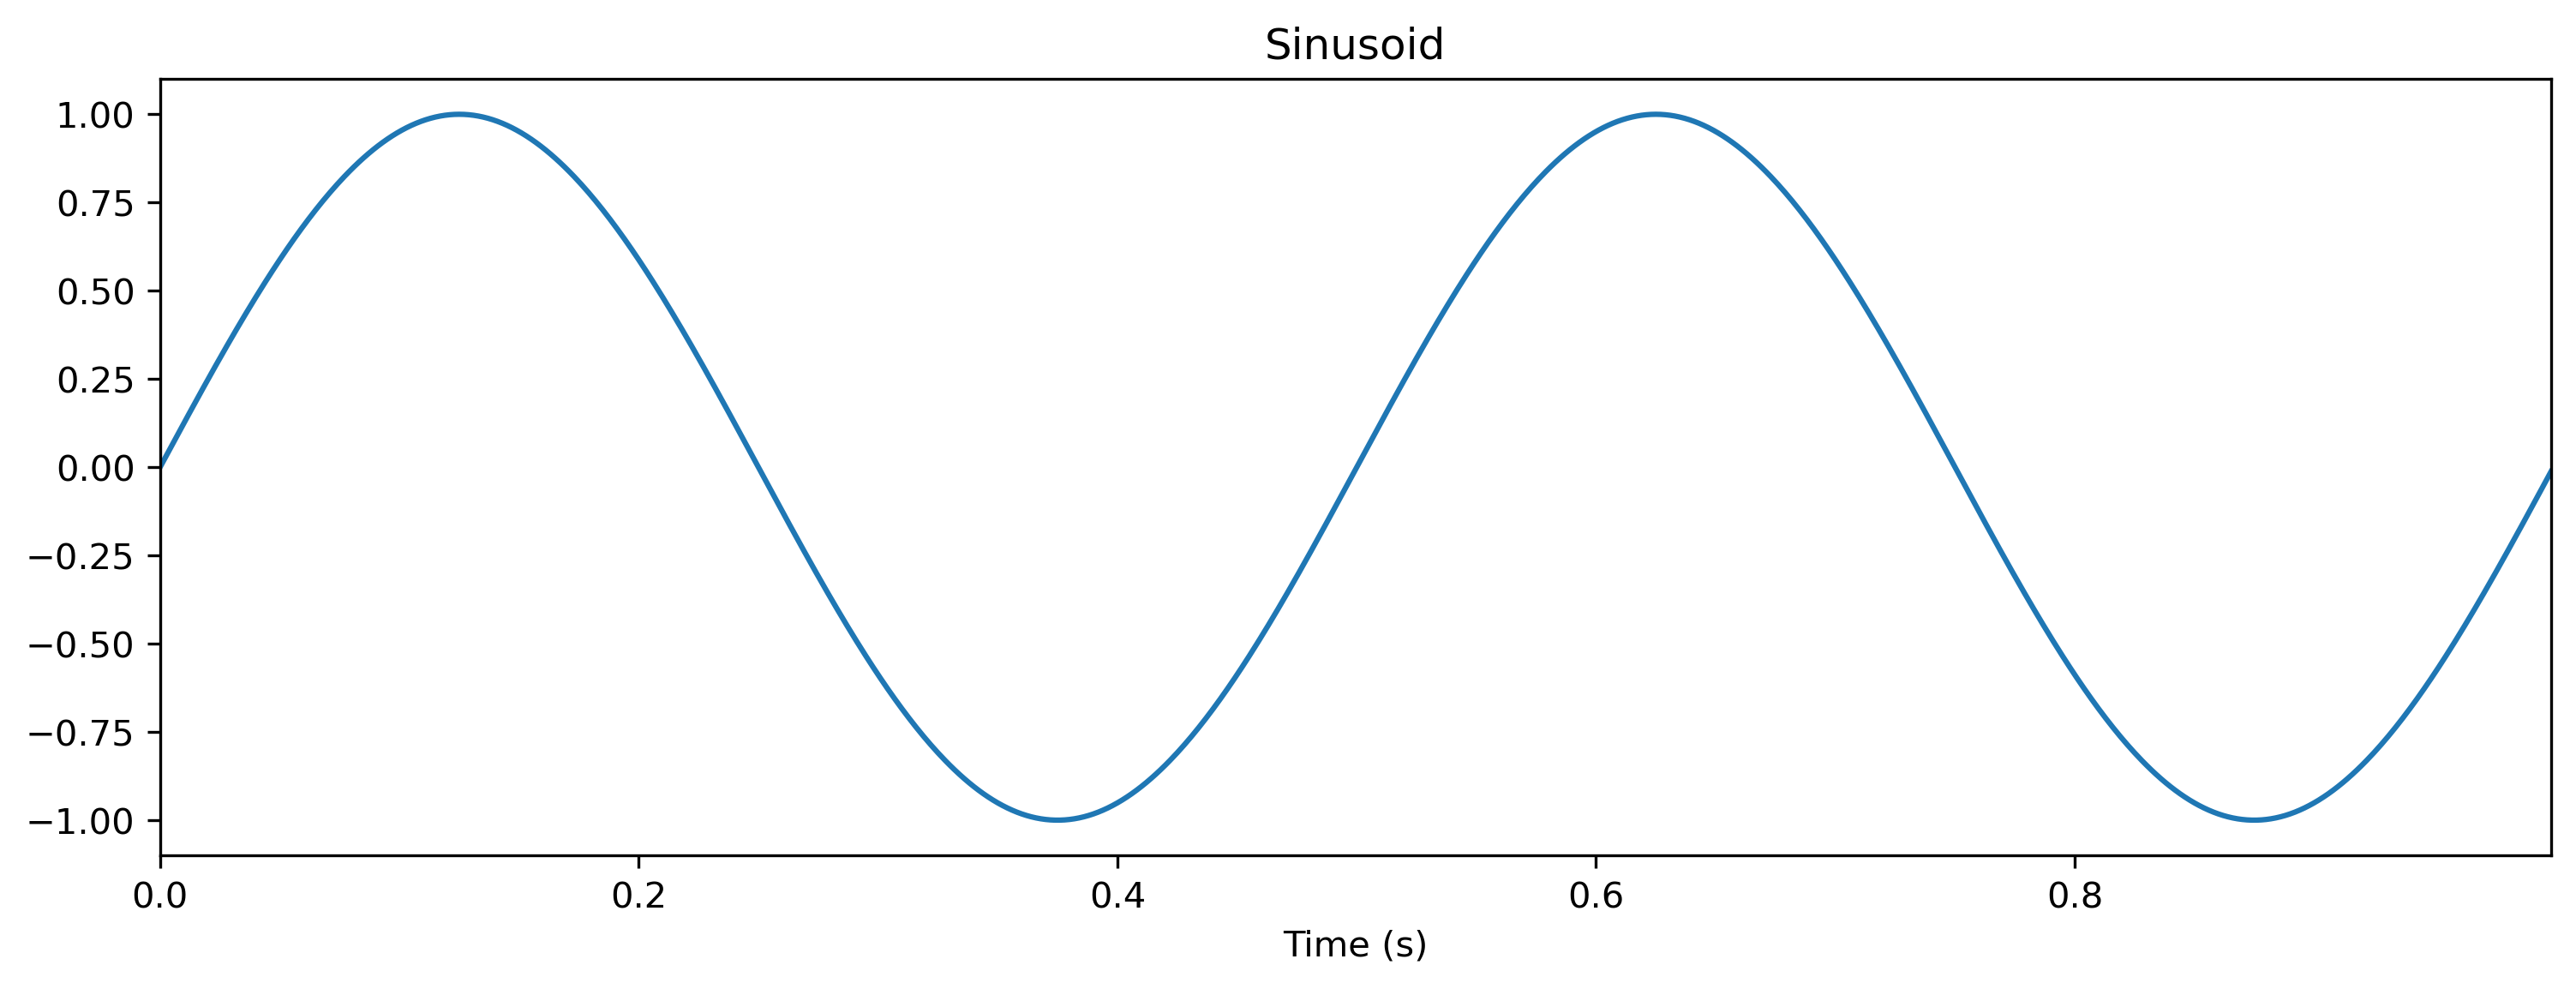

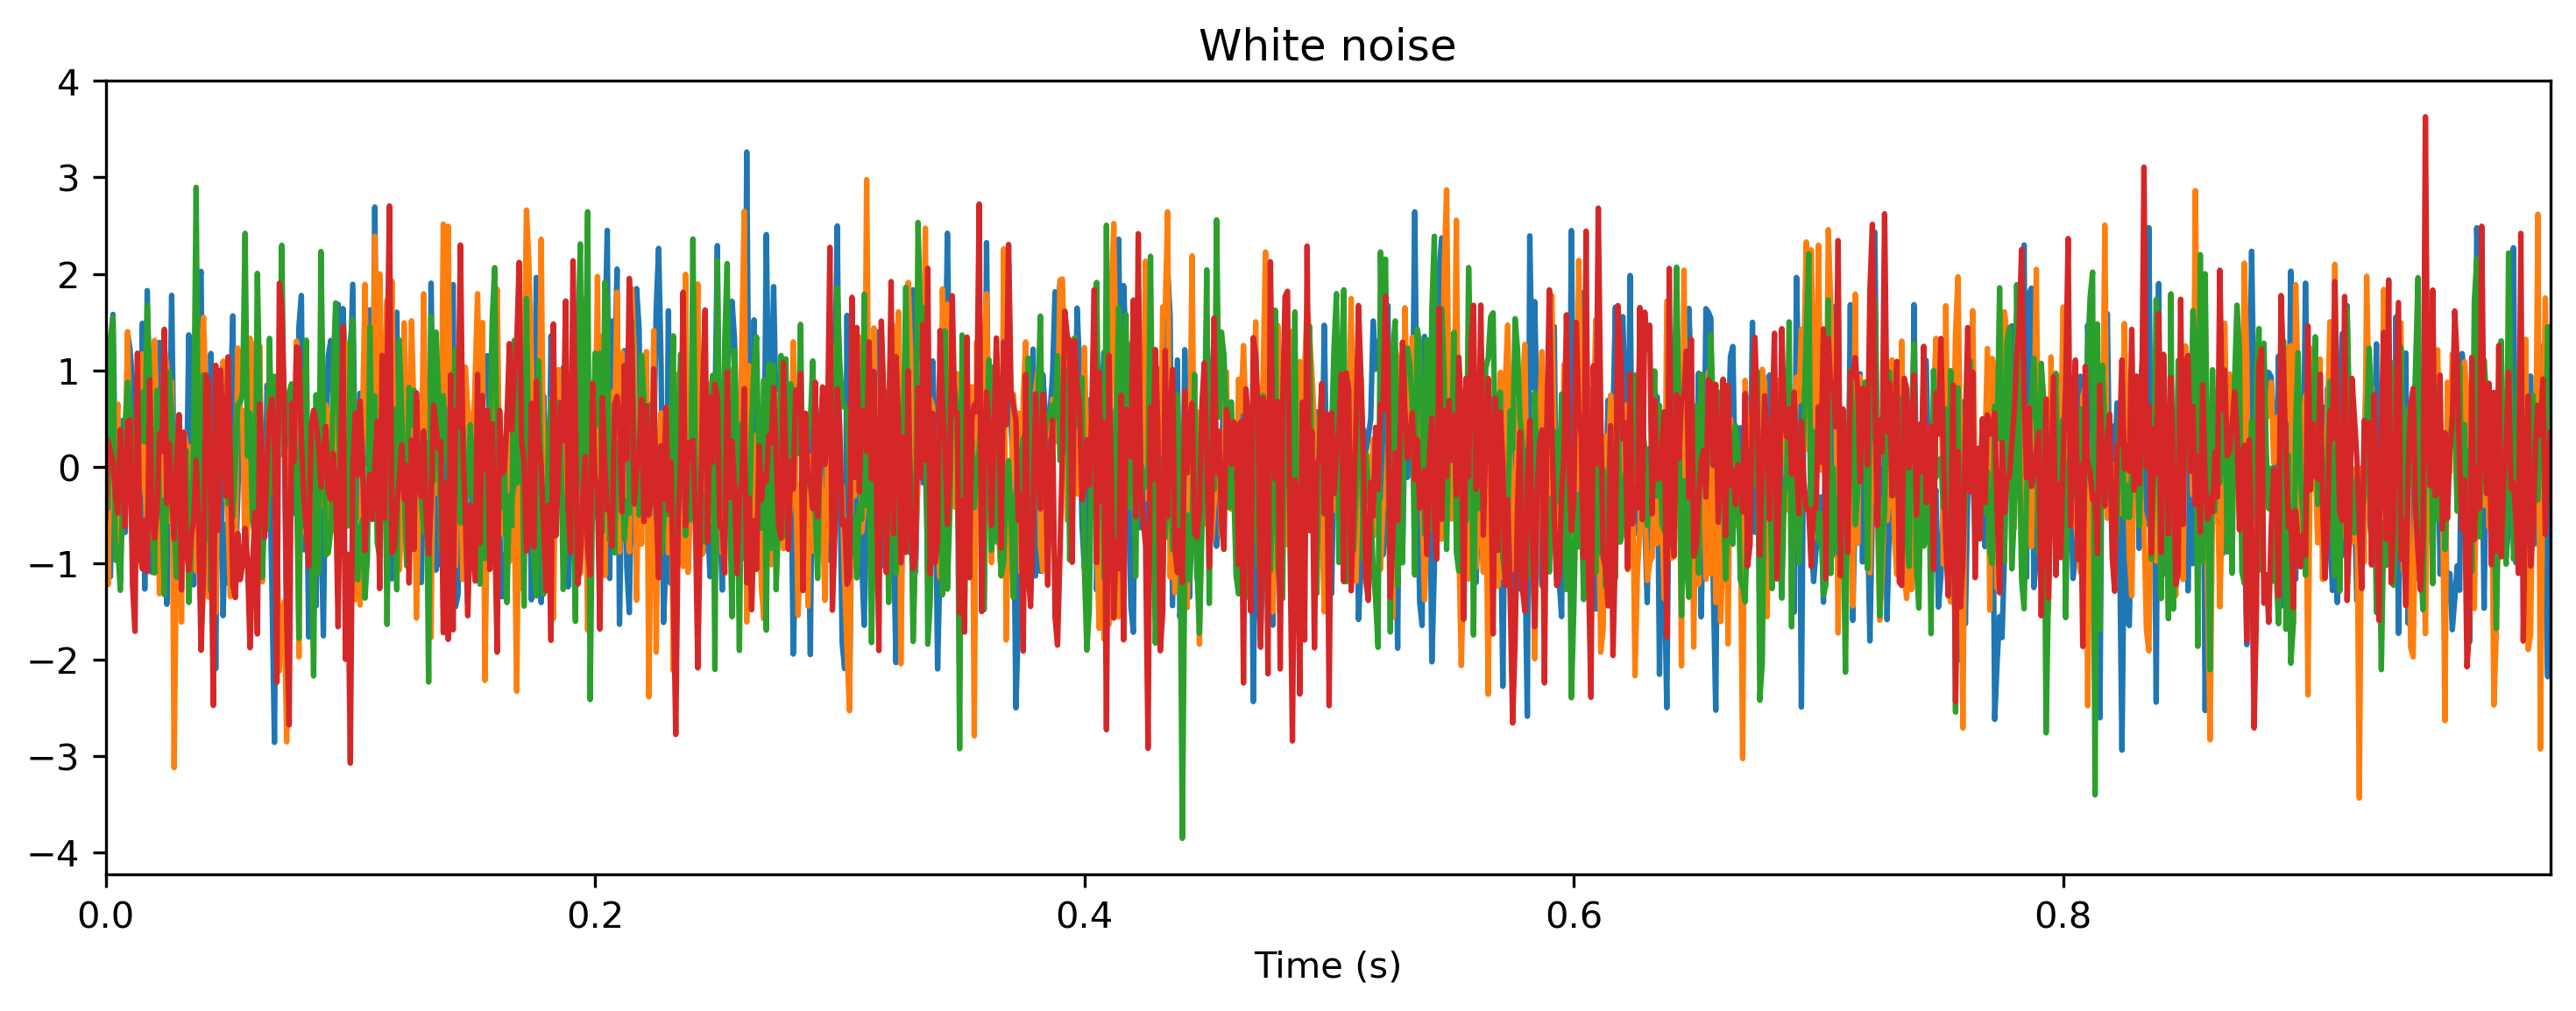

In [8]:
dt = 1e-3
T = 1000
time_base = np.arange(T) * dt

# - Generate a sinusoidal time series
freq = 2
ts_sin = TSContinuous(
    times=time_base,
    samples=np.sin(time_base * 2 * np.pi * freq),
    periodic=True,
    name="Sinusoid",
)
plt.figure()
ts_sin.plot()

# - Generate a noise time series
amp = 1
ts_noise = TSContinuous.from_clocked(
    samples=np.random.randn(T, N), dt=dt, periodic=True, name="White noise"
)
plt.figure()
ts_noise.plot();

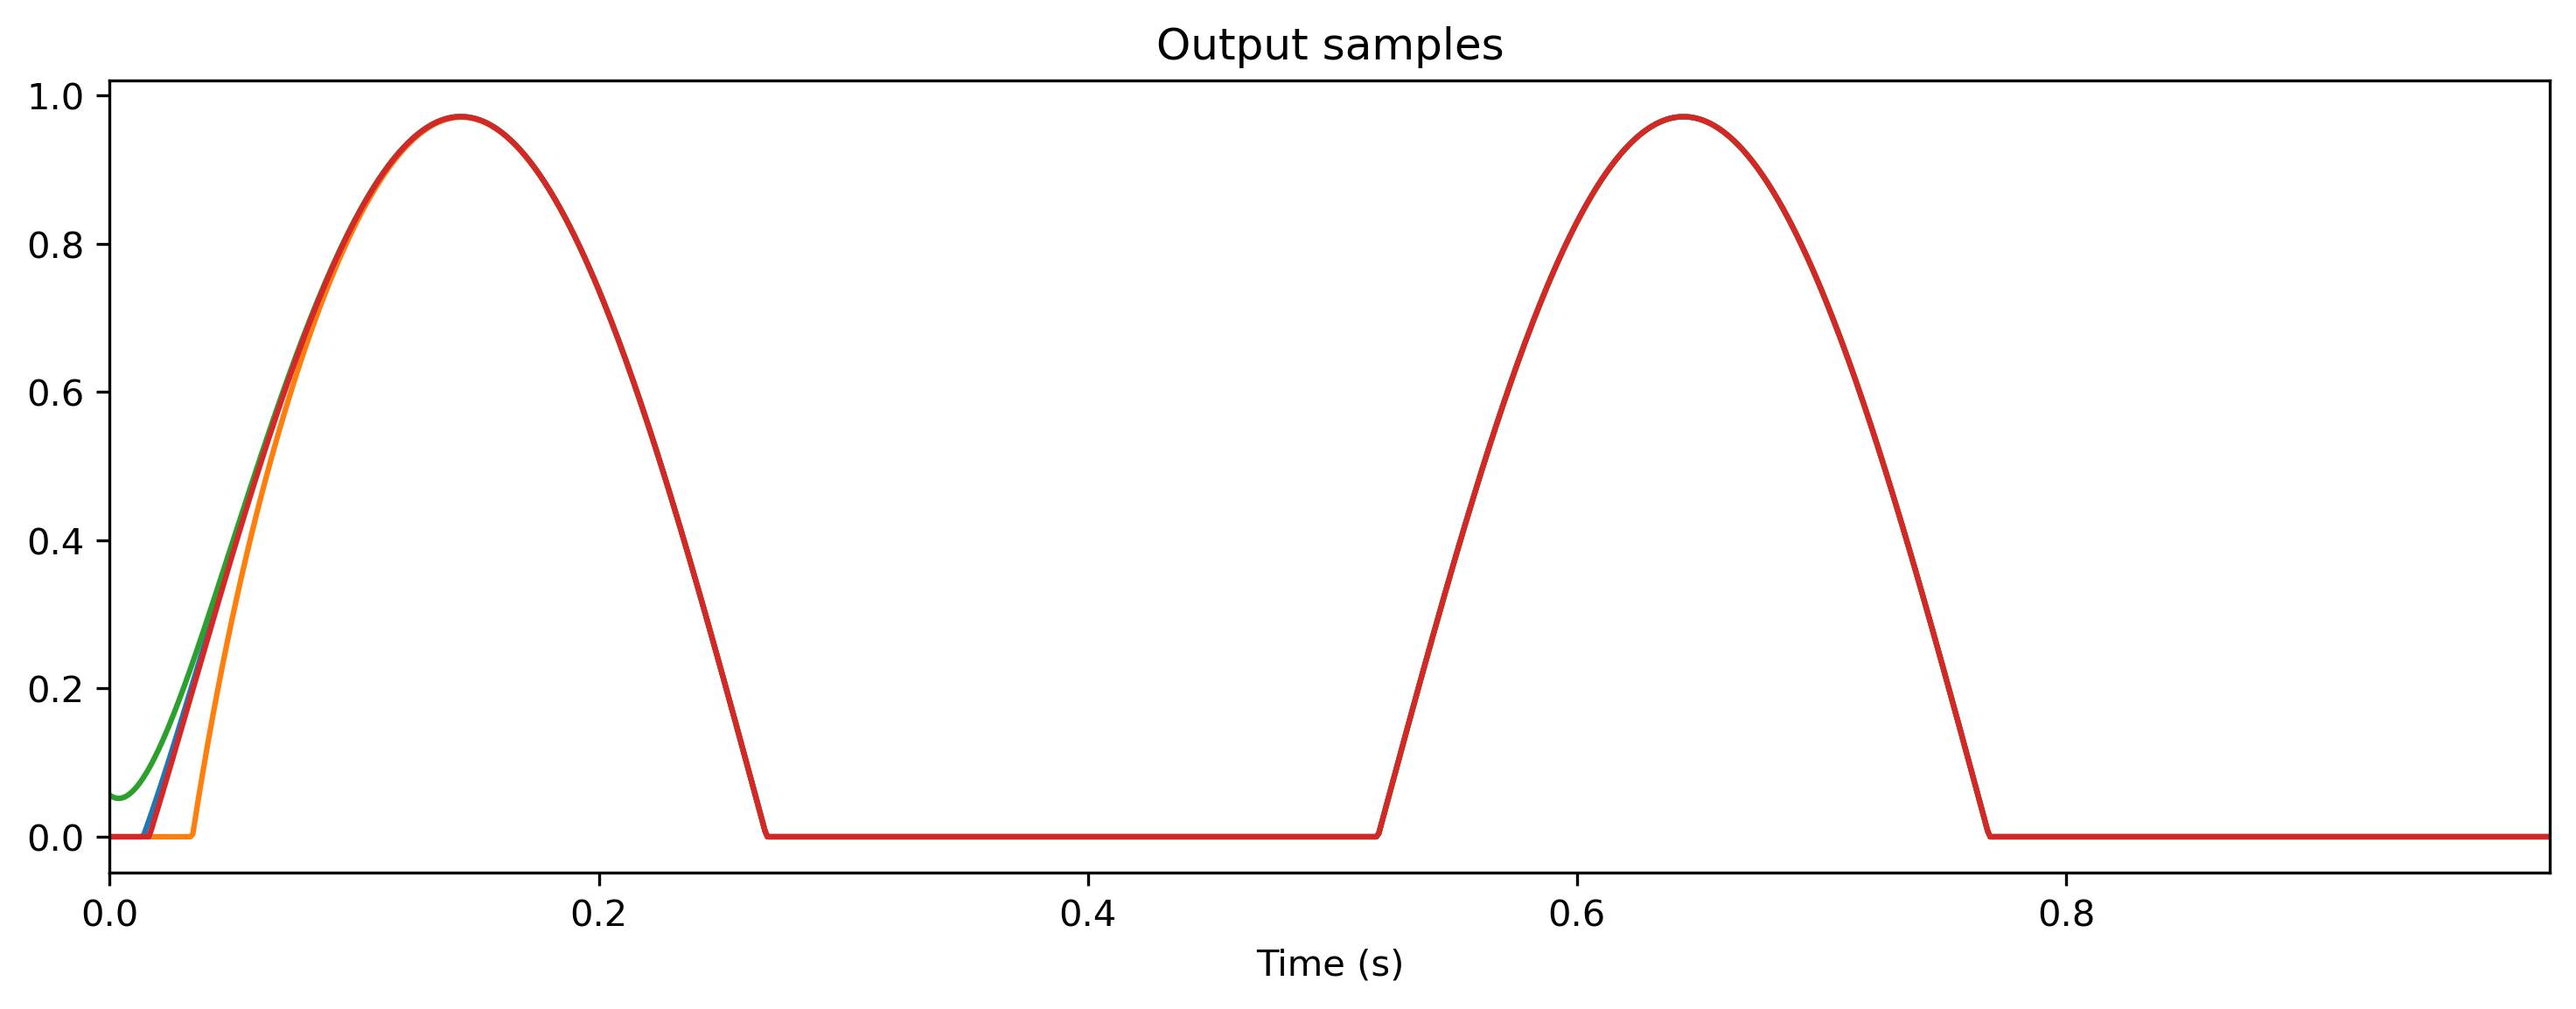

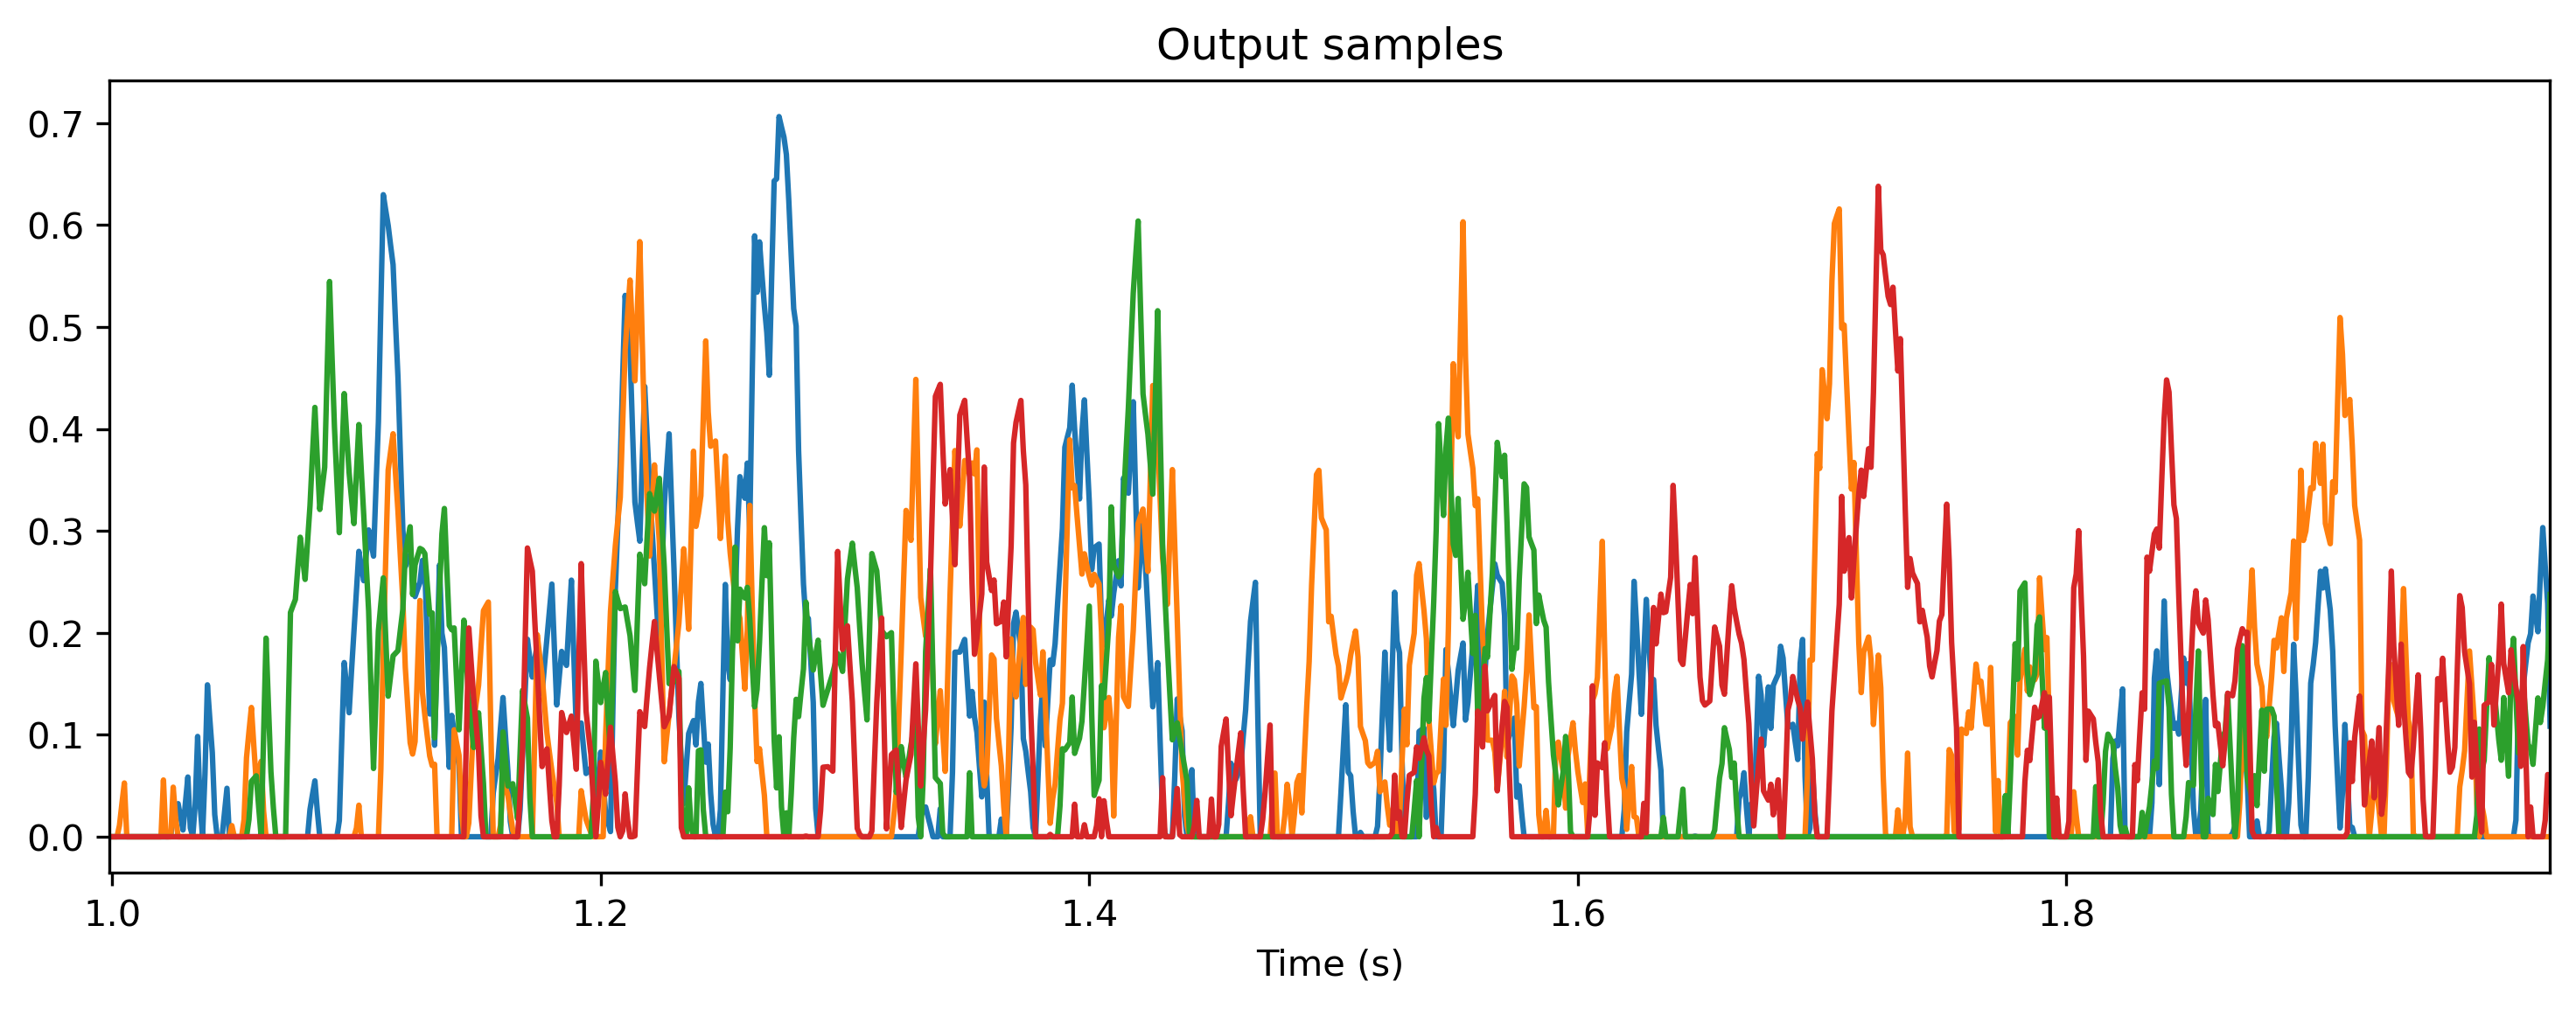

In [9]:
# - Evolve the timed module
output, new_state, _ = tmod(ts_sin)
plt.figure()
output.plot()

output, new_state, _ = tmod(ts_noise)
plt.figure()
output.plot();

## Building networks by composing and combining modules

In [10]:
# - Import the required modules
from rockpool.nn.modules import Linear, Rate

# - Import the `Sequential` combinator
from rockpool.nn.combinators import Sequential

# - Define the network size
input_size = 1
hidden_size = 10
output_size = 1

# - Build a sequential stack of modules
seqmod = Sequential(
    Linear((input_size, hidden_size)),
    Rate(hidden_size),
    Linear((hidden_size, input_size)),
)
print(seqmod)

ModSequential  with shape (1, 1) {
    Linear '0_Linear' with shape (1, 10)
    Rate '1_Rate' with shape (10,)
    Linear '2_Linear' with shape (10, 1)
}

We can once again call the module to pass data through the network.

In [11]:
input_clocked = np.random.rand(T, 1)
output, state, _ = seqmod(input_clocked)

We can inspect the set of parameters and state of the module using the same methods as before, as well as the `modules` method to view submodules.

In [12]:
print("Parameters:", seqmod.parameters(), "\n")
print("State:", seqmod.state(), "\n")
print("Modules:", seqmod.modules(), "\n")

Parameters:
{
    '0_Linear': {
        'weight': array([[ 1.00720834,  2.41430863,  2.05452097,  0.26908395,  0.87390412,
         0.16776011, -1.02723335, -2.21785861,  1.59488468,  1.98906917]])
    },
    '1_Rate': {
        'tau': array([0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02]),
        'bias': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
        'threshold': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
    },
    '2_Linear': {
        'weight': array([[-0.69257277],
       [-0.46641828],
       [-0.70623862],
       [ 0.57026507],
       [ 0.41529622],
       [-0.71813582],
       [ 0.20873922],
       [ 0.70115382],
       [-0.55436738],
       [-0.44933562]])
    }
}

State:
{
    '0_Linear': {},
    '1_Rate': {
        'x': array([ 0.45167469,  1.08267778,  0.92133383,  0.12066859,  0.39189545,
        0.07523071, -0.46065474, -0.99458131,  0.71521353,  0.89198248])
    },
    '2_Linear': {}
}

Modules:
OrderedDict([('0_Linear', Linear '0_Linear' with shape (1, 10)), ('1_Rate', Rate '1_Rate' with shape (10,)), 
('2_Linear', Linear '2_Linear' with shape (10, 1))])

Parameters and states in Rockpool can be assigned families, such as "weights" and "taus". This is used to to conveniently pull out classes of parameters, and can be passed as an argument to the `parameters` and `state` methods.

In [13]:
print(seqmod.parameters("weights"))

{
    '0_Linear': {
        'weight': array([[ 1.00720834,  2.41430863,  2.05452097,  0.26908395,  0.87390412,
         0.16776011, -1.02723335, -2.21785861,  1.59488468,  1.98906917]])
    },
    '2_Linear': {
        'weight': array([[-0.69257277],
       [-0.46641828],
       [-0.70623862],
       [ 0.57026507],
       [ 0.41529622],
       [-0.71813582],
       [ 0.20873922],
       [ 0.70115382],
       [-0.55436738],
       [-0.44933562]])
    }
}

In [14]:
# - Import the `OrderedDict` class
from collections import OrderedDict

# - Build an ordered dictionary of modules, specifying the name as each key
modules = OrderedDict([
    ("lin1", Linear((input_size, hidden_size))),
    ("rate1", Rate(hidden_size)),
    ("lin2", Linear((hidden_size, input_size))),
])

# - Build a `Sequential` network
seqmod = Sequential(modules)
print(seqmod)

ModSequential  with shape (1, 1) {
    Linear 'lin1' with shape (1, 10)
    Rate 'rate1' with shape (10,)
    Linear 'lin2' with shape (10, 1)
}

In [15]:
# - Start with an empty `Sequential` network
seqmod = Sequential()

# - Append modules in turn, specifying the submodule names
seqmod.append(Linear((input_size, hidden_size)), "lin1")
seqmod.append(Rate(hidden_size), "rate1")
seqmod.append(Linear((hidden_size, input_size)), "lin2")

print(seqmod)

ModSequential  with shape (1, 1) {
    Linear 'lin1' with shape (1, 10)
    Rate 'rate1' with shape (10,)
    Linear 'lin2' with shape (10, 1)
}

## Building a custom nested modules

In [16]:
# - Import the required modules
from rockpool.nn.modules import Linear, Rate, Module

# - Parameters are specified using the `Parameter` and `State`
from rockpool.parameters import Parameter, State, SimulationParameter

# - Design the network architecture
#   Every module inherits from Module
class net(Module):
    # - Every module needs an `__init__()` method to specify parameters
    def __init__(self, shape: tuple, *args, **kwargs):
        # - Every module must call `super().__init__()`
        super().__init__(shape, *args, **kwargs)

        # - Configure weight parameters
        self.w_input = Parameter(
            shape=self.shape[0:2],
            family="weights",
            init_func=lambda size: np.random.normal(size=size),
        )
        self.w_output = Parameter(
            shape=self.shape[1:],
            family="weights",
            init_func=lambda size: np.random.normal(size=size),
        )

        # - Build submodules
        self.mod_recurrent = Rate((shape[1], shape[1]), has_rec=True)

    # - Every module needs an `evolve()` method
    def evolve(self, input, record: bool = False) -> (np.array, np.array, dict):
        # - Initialise output arguments
        new_state = {}
        record_dict = {}

        # - Pass input through the input weights and submodule
        x, mod_state, mod_record_dict = self.mod_recurrent(
            np.dot(input, self.w_input), record
        )

        # - Maintain the submodule state and recorded state dictionaries
        new_state.update({"mod_recurrent": mod_state})
        record_dict.update({"mod_recurrent": mod_record_dict})

        # - Pass data through the output weights
        output = np.dot(x, self.w_output)

        # - Return outputs
        return output, new_state, record_dict

Now we can instantiate a module based on our `net` class, and test it by passing data through.

In [17]:
# - Define the network size
input_size = 4
rec_size = 3
output_size = 2

# - Instantiate a module
net_mod = net(shape=(input_size, rec_size, output_size))
print(net_mod)

net  with shape (4, 3, 2) {
    Rate 'mod_recurrent' with shape (3, 3)
}

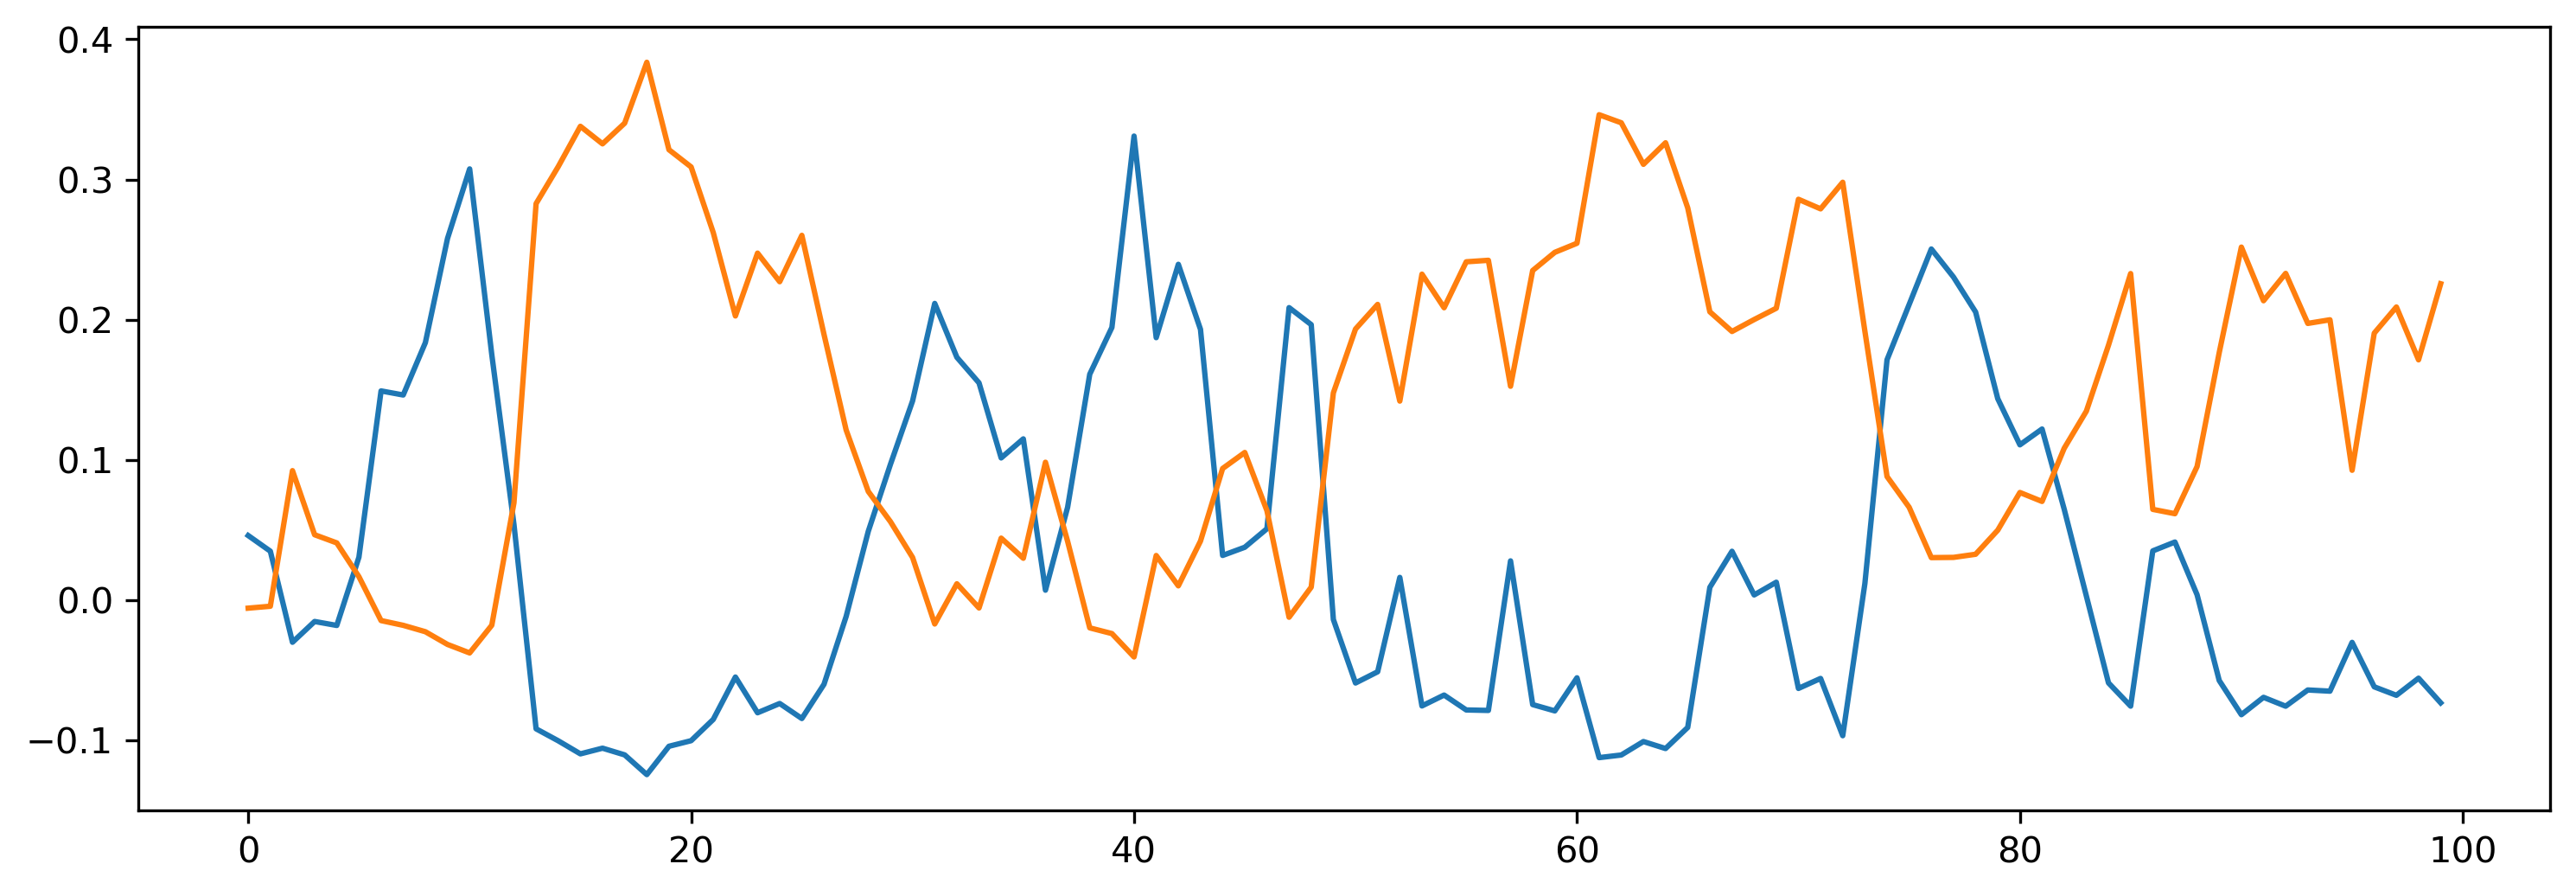

In [18]:
# - Define an input
T = 100
input = np.random.randn(T, input_size)

# - Evolve the module
output, new_state, recorded_state = net_mod(input)
net_mod = net_mod.set_attributes(new_state)
plt.plot(output[0]);

If we inspect our network parameters, we can see they follow the structure of the module heirarchy, and include parameters defined by the sub-modules.

In [19]:
print(net_mod.parameters())

{
    'w_input': array([[ 1.41978838, -1.13184915, -0.74752138],
       [-0.95091877,  0.30172439,  0.35265   ],
       [-0.09663117,  0.10782144, -1.36449476],
       [-0.72311345,  0.10093025, -0.2414413 ]]),
    'w_output': array([[-0.20141784,  0.62143563],
       [ 1.22627445, -0.14979523],
       [-1.53157303,  0.67460225]]),
    'mod_recurrent': {
        'w_rec': array([[ 0.15648791,  0.401766  , -1.14040351],
       [ 0.42543312,  0.5842613 , -0.30617398],
       [-0.81748013, -1.23444556, -0.26348427]]),
        'tau': array([0.02, 0.02, 0.02]),
        'bias': array([0., 0., 0.]),
        'threshold': array([0., 0., 0.])
    }
}

You can set the parameters of the network directly by setting attributes:

In [20]:
# - Define weights
weights_in = np.random.rand(input_size, rec_size) - 0.5
weights_rec = np.random.randn(rec_size, rec_size) / rec_size
weights_out = np.random.rand(rec_size, output_size) - 0.5

# - Set the weights
net_mod.w_input = weights_in
net_mod.mod_recurrent.w_rec = weights_rec
net_mod.w_output = weights_out

# - Display the network
print(net_mod.parameters())

{
    'w_input': array([[ 0.28506196,  0.02794232,  0.05052549],
       [-0.39742499,  0.13996292, -0.191019  ],
       [-0.0180503 , -0.03285261,  0.01811005],
       [ 0.05156022, -0.23567097, -0.29003133]]),
    'w_output': array([[-0.28148003, -0.02212604],
       [-0.23931323,  0.24881792],
       [-0.41053964, -0.33932346]]),
    'mod_recurrent': {
        'w_rec': array([[-0.91369668,  0.15297224,  0.4534814 ],
       [ 0.05805358,  0.35401688, -0.29566064],
       [ 0.2393718 , -0.02951023, -0.00684574]]),
        'tau': array([0.02, 0.02, 0.02]),
        'bias': array([0., 0., 0.]),
        'threshold': array([0., 0., 0.])
    }
}

## Next steps